# Simple reliability script [WIP]

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, multivariate_normal

In [22]:
# Define the limit state function G(X1, X2)
def limit_state_function(x):
    X1, X2 = x
    return X1 + X2 - 5  # G(X1, X2) = X1 + X2 - 5

# Adapt to other distributions
# Transform to standard normal space (assume mean and std are provided)
def standard_normal_transform(x, means, std_devs):
    """Transform X into U (standard normal space)"""
    return (x - means) / std_devs

# Transform back to original space with correct broadcasting
def original_space_transform(u, means, std_devs):
    """Transform U back to X (original space), ensuring correct broadcasting."""
    return u * std_devs[:, None, None] + means[:, None, None]

# Objective function for FORM (minimize the distance to the origin in standard normal space)
def objective_function(u):
    """Objective function to minimize: distance from origin in standard normal space"""
    return np.linalg.norm(u)  # Minimize the norm of U (distance to origin)

# Constraint for FORM (limit state function G(X) = 0)
def constraint(u, means, std_devs):
    """The constraint G(X) = 0"""
    x = u * std_devs + means
    #x = original_space_transform(u, means, std_devs)
    return limit_state_function(x)

# Perform FORM analysis
def form_analysis(means, std_devs, initial_guess):
    """Performs FORM to find the reliability index and sensitivity factors"""
    constraints = {'type': 'eq', 'fun': constraint, 'args': (means, std_devs)}
    
    # Minimize the objective function subject to G(X) = 0
    result = minimize(objective_function, initial_guess, constraints=constraints, method='SLSQP')
    
    if not result.success:
        print("Optimization failed")
        return None
    
    # Design point in standard normal space
    design_point_u = result.x
    
    # Reliability index beta is the distance to the origin
    beta = np.linalg.norm(design_point_u)
    
    # Sensitivities (alpha) are the direction cosines (normalized design point)
    alpha = design_point_u / beta
    
    # Transform design point back to physical space
    design_point_x = design_point_u * std_devs + means
    
    return beta, alpha, design_point_u, design_point_x

# Plotting the joint PDF in original space and standard normal space
def plot_joint_pdf(means, std_devs, limit_state_function, design_point_x, design_point_u, beta):
    # Grid for the original space (X1, X2)
    x1 = np.linspace(means[0] - 3*std_devs[0], means[0] + 3*std_devs[0], 100)
    x2 = np.linspace(means[1] - 3*std_devs[1], means[1] + 3*std_devs[1], 100)
    X1, X2 = np.meshgrid(x1, x2)

    # Evaluate the limit state function over the grid
    Z = limit_state_function([X1, X2])
    
    # Joint PDF in original space
    rv_original = multivariate_normal(mean=means, cov=np.diag(std_devs**2))
    pdf_original = rv_original.pdf(np.dstack((X1, X2)))

    # Plot the PDF and the limit state in original space
    plt.figure(figsize=(12, 6))

    # Plot in original space
    plt.subplot(1, 2, 1)
    plt.contourf(X1, X2, pdf_original, levels=20, cmap='Blues')
    plt.contour(X1, X2, Z, levels=[0], colors='red', linewidths=2)  # Limit state G(X) = 0
    plt.scatter(design_point_x[0], design_point_x[1], color='red', label=f'Design Point X*')
    plt.title('Original Space (X1, X2)')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.axis('square')

    # Grid for the standard normal space (U1, U2)
    u1 = np.linspace(-3, 3, 100)
    u2 = np.linspace(-3, 3, 100)
    U1, U2 = np.meshgrid(u1, u2)
    
    # Transform the U1, U2 grid to X1, X2 space and evaluate the limit state function
    Z_u = limit_state_function(original_space_transform(np.array([U1, U2]), means, std_devs))
    
    # Joint PDF in standard normal space
    rv_normal = multivariate_normal(mean=[0, 0], cov=np.eye(2))
    pdf_normal = rv_normal.pdf(np.dstack((U1, U2)))

    # Plot in standard normal space
    plt.subplot(1, 2, 2)
    plt.contourf(U1, U2, pdf_normal, levels=20, cmap='Blues')
    plt.contour(U1, U2, Z_u, levels=[0], colors='red', linewidths=2)  # Limit state G(U) = 0
    plt.scatter(design_point_u[0], design_point_u[1], color='red', label=f'Design Point U* (Beta={beta:.2f})')
    plt.title('Standard Normal Space (U1, U2)')
    plt.xlabel('U1')
    plt.ylabel('U2')
    plt.legend()
    plt.axis('square')

    plt.tight_layout()
    plt.show()

Reliability Index (Beta): 1.264911065347121
Probability of failure (Pf): 0.05433615894725531
Sensitivities at Design Point (Alpha): [-0.94866907 -0.31627044]
Design Point in Standard Normal Space (U): [-1.19998201 -0.40005398]
Design Point in Original Space (X): [2.20002699 2.79997301]


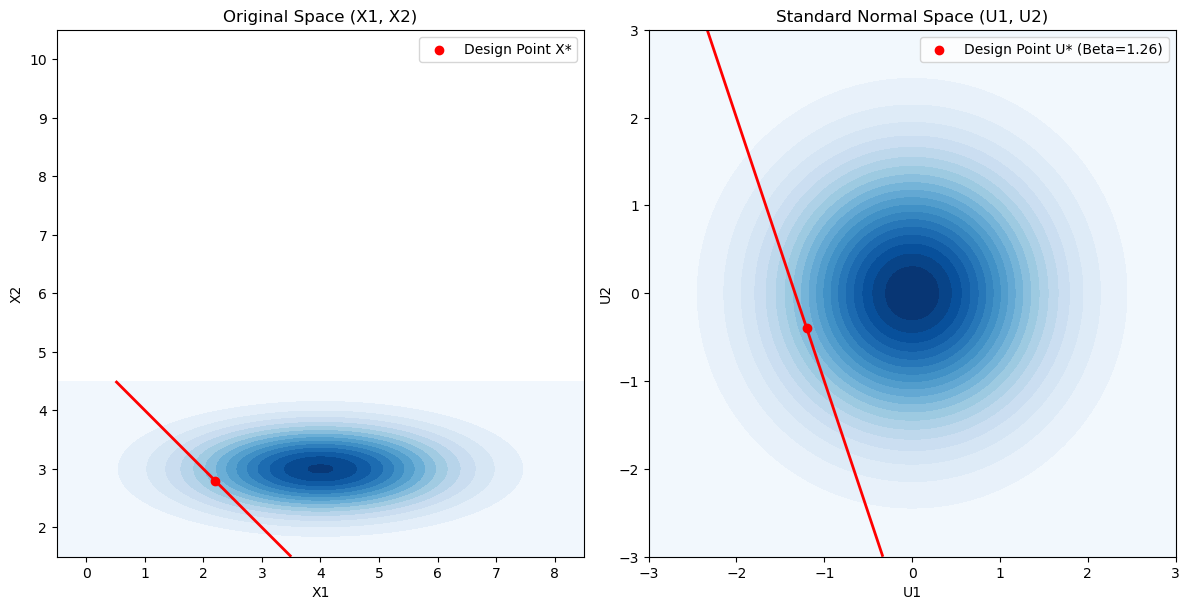

In [32]:
# Means and standard deviations of the two random variables
means = np.array([4.0, 3.0])      # Mean values of X1 and X2
std_devs = np.array([1.5, 0.5])   # Standard deviations of X1 and X2

# Initial guess for the optimization (in standard normal space)
initial_guess = np.array([0.0, 0.0])  # Start at the origin in U-space

# Run FORM analysis
beta, alpha, design_point_u, design_point_x = form_analysis(means, std_devs, initial_guess)

# Output the results
print(f"Reliability Index (Beta): {beta}")
print(f"Probability of failure (Pf): {np.power(10,-beta)}")
print(f"Sensitivities at Design Point (Alpha): {alpha}")
print(f"Design Point in Standard Normal Space (U): {design_point_u}")
print(f"Design Point in Original Space (X): {design_point_x}")

# Plot the joint PDFs in original and standard normal space
plot_joint_pdf(means, std_devs, limit_state_function, design_point_x, design_point_u, beta)